In [1]:
import tensorflow as tf
tf.enable_eager_execution()
# Check eager execution is enabled
print(tf.executing_eagerly())        # => True

True


In [2]:
from os.path import join, split, splitext
from glob import glob

DATASET_PATH = '/home/sean/Storage/Datasets/Birp'
WAV_PATH = join(DATASET_PATH, 'wav')
MSPEC_PATH = join(DATASET_PATH, 'melspecs')
ZOOMED_PATH = join(DATASET_PATH, 'zoomed')
FLAT_PATH = join(DATASET_PATH, 'flat')

wav_files = glob(join(WAV_PATH, '*.wav'))
npy_files = glob(join(MSPEC_PATH, '*.npy'))
zoomed_files = glob(join(ZOOMED_PATH, '*.npy'))
flat_files = glob(join(FLAT_PATH, '*.npy'))

In [3]:
def read_waveform(filepath, sampling_rate=44100):
    wav_binary = tf.read_file(filepath)

    waveform = tf.contrib.ffmpeg.decode_audio (
        wav_binary, 
        file_format='wav', 
        samples_per_second=sampling_rate, 
        channel_count=1
    )
    
    return waveform

In [4]:
# FOR DEMO PURPOSES

import matplotlib.pyplot as plt

sampling_rate = 44100

waveform = read_waveform(wav_files[0])
print(waveform.numpy().shape)

# Plot a section of the waveform.
plt.plot(waveform.numpy().flatten())
plt.show()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This will be deleted and should not be used.
(4299750, 1)


<Figure size 640x480 with 1 Axes>

In [5]:
# FOR DEMO PURPOSES

# Reshape the signals to shape of (batch_size, samples).
signals = tf.reshape(waveform, [1, -1])

# Step 1 : signals->stfts
# `stfts` is a complex64 Tensor representing the Short-time Fourier Transform of
# each signal in `signals`. Its shape is [batch_size, ?, fft_unique_bins]
# where fft_unique_bins = fft_length // 2 + 1 = 513.
stfts = tf.contrib.signal.stft(
    signals, 
    frame_length=1024, 
    frame_step=512, 
    fft_length=1024
)

In [6]:
# FOR DEMO PURPOSES

# An energy spectrogram is the magnitude of the complex-valued STFT.
# A float32 Tensor of shape [batch_size, ?, 513].
magnitude_spectrograms = tf.abs(stfts)

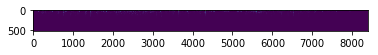

In [7]:
# FOR DEMO PURPOSES

import numpy as np
array = magnitude_spectrograms.numpy().astype(np.float)[0]
plt.imshow(np.swapaxes(array,0,1))

(1, 8396, 64)


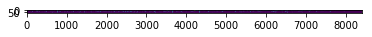

In [8]:
# FOR DEMO PURPOSES

# Warp the linear-scale, magnitude spectrograms into the mel-scale.
num_spectrogram_bins = magnitude_spectrograms.shape[-1].value

lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 8000, 64

linear_to_mel_weight_matrix = tf.contrib.signal.linear_to_mel_weight_matrix(
    num_mel_bins, 
    num_spectrogram_bins, 
    sampling_rate, 
    lower_edge_hertz, 
    upper_edge_hertz
)

mel_spectrograms = tf.tensordot(magnitude_spectrograms, linear_to_mel_weight_matrix, 1)

print(mel_spectrograms.numpy().shape)

array = mel_spectrograms.numpy().astype(np.float)[0]
plt.imshow(np.swapaxes(array,0,1))

(1, 8396, 64)
(8396, 64)


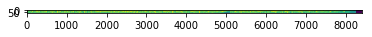

In [9]:
# FOR DEMO PURPOSES

log_offset = 1e-6
log_mel_spectrograms = tf.log(mel_spectrograms + log_offset)

print(log_mel_spectrograms.numpy().shape)
array = log_mel_spectrograms.numpy()[0]
print(array.shape)
plt.imshow(np.swapaxes(array,0,1))

In [10]:
for wav in wav_files:
    if join(MSPEC_PATH, splitext(split(wav)[1])[0][6:] + '.npy') not in npy_files:
        print('Processing', split(wav)[1], '...')
        waveform = read_waveform(wav)
        # Reshape the signals to shape of (batch_size, samples).
        signals = tf.reshape(waveform, [1, -1])

        # Step 1 : signals->stfts
        # `stfts` is a complex64 Tensor representing the Short-time Fourier Transform of
        # each signal in `signals`. Its shape is [batch_size, ?, fft_unique_bins]
        # where fft_unique_bins = fft_length // 2 + 1 = 513.
        stfts = tf.contrib.signal.stft(signals, frame_length=1024, frame_step=512, fft_length=1024)

        # An energy spectrogram is the magnitude of the complex-valued STFT.
        # A float32 Tensor of shape [batch_size, ?, 513].
        magnitude_spectrograms = tf.abs(stfts)

        # Warp the linear-scale, magnitude spectrograms into the mel-scale.
        num_spectrogram_bins = magnitude_spectrograms.shape[-1].value

        sampling_rate, lower_edge_hertz, upper_edge_hertz, num_mel_bins = 44100, 80.0, 8000, 64

        linear_to_mel_weight_matrix = tf.contrib.signal.linear_to_mel_weight_matrix(
            num_mel_bins, 
            num_spectrogram_bins, 
            sampling_rate, 
            lower_edge_hertz, 
            upper_edge_hertz
        )

        mel_spectrograms = tf.tensordot(magnitude_spectrograms, linear_to_mel_weight_matrix, 1)

        log_offset = 1e-6
        log_mel_spectrograms = tf.log(mel_spectrograms + log_offset)

        array = log_mel_spectrograms.numpy()[0]
        print(array.shape)

        np.save(join(MSPEC_PATH, splitext(split(wav)[1])[0][6:] + '.npy'), array)

In [11]:
from scipy.ndimage import zoom

target_length = 5000

for npy in npy_files:
    if join(ZOOMED_PATH, split(npy)[1]) not in zoomed_files:
        print('Processing', split(npy)[1], '...')
        array = np.load(npy)
        
        zoom_factor = (target_length / array.shape[0], 1.0)
        zoomed_array = zoom(array, zoom_factor)[0:target_length, :]
        
        print(zoomed_array.shape)
        
        np.save(join(ZOOMED_PATH, split(npy)[1]), zoomed_array)

In [12]:
for i, npy in enumerate(npy_files):
    if join(FLAT_PATH, split(npy)[1]) not in flat_files:
        print('Processing', split(npy)[1], '...')
        array = np.load(npy)[:target_length, :]
        
        flat_array = np.reshape(array, array.shape[0] * array.shape[1])
        
        print(flat_array.shape)
        
        np.save(join(FLAT_PATH, split(npy)[1]), flat_array)

In [13]:
data = []

for npy in flat_files:
    data.append(np.load(npy))

In [20]:
%load_ext wurlitzer
from time import time
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA

X = np.array(data)

start_time = time()
pca = PCA(n_components=955).fit_transform(X)
print("PCA finished in {0:.2f} seconds.".format(time() - start_time))

start_time = time()
embedded = TSNE(n_jobs=8, n_iter=3000, verbose=2).fit_transform(pca)
# embedded = np.load('embedded.npy')
print("t-SNE finished in {0:.2f} seconds.".format(time() - start_time))

The wurlitzer extension is already loaded. To reload it, use:
  %reload_ext wurlitzer
PCA finished in 103.02 seconds.


Performing t-SNE using 8 cores.
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 95 of 955
 - point 190 of 955
 - point 285 of 955
 - point 380 of 955
 - point 475 of 955
 - point 570 of 955
 - point 665 of 955
 - point 760 of 955
 - point 855 of 955
 - point 950 of 955
Done in 0.00 seconds (sparsity = 0.156294)!
Learning embedding...
Iteration 51: error is 71.758127 (50 iterations in 1.00 seconds)
Iteration 101: error is 70.029459 (50 iterations in 0.00 seconds)
Iteration 151: error is 71.795960 (50 iterations in 0.00 seconds)
Iteration 201: error is 72.211035 (50 iterations in 0.00 seconds)
Iteration 251: error is 71.899938 (50 iterations in 0.00 seconds)
Iteration 301: error is 1.734616 (50 iterations in 0.00 seconds)
Iteration 351: error is 1.636384 (50 iterations in 0.00 seconds)
Iteration 401: error is 1.614842 (50 iterations in 0.00 seconds)
Iteration 451: error is 1.598325 (50 iterations in 1.00 seconds)
I

t-SNE finished in 7.42 seconds.


Iteration 3000: error is 1.560671 (50 iterations in 0.00 seconds)
Fitting performed in 7.00 seconds.


In [28]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=1, min_samples=5, n_jobs=7).fit_predict(X)

print(clustering)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

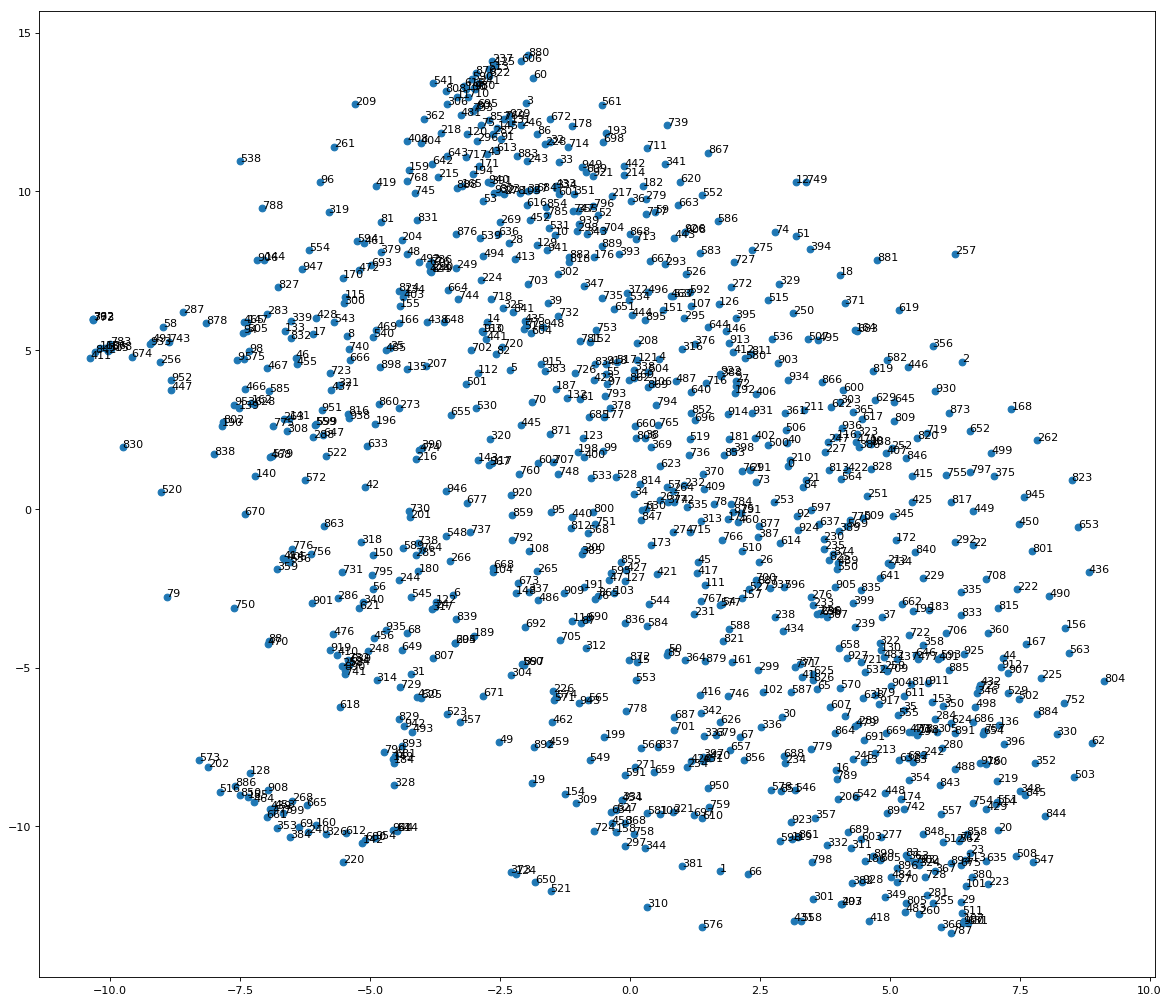

In [27]:
fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plt.scatter(embedded[:, 0], embedded[:, 1])

for i in range(len(embedded)):
    plt.annotate(i, embedded[i])

plt.show()

In [51]:
def get_cluster(song_id, embedding, threshold=1, done=None, max_num=50):
    song = embedding[song_id]
    if done is None:
        done = set()
        
    if len(done) > max_num:
        return set()
        
    next_songs = []
    
    for i, other_song in enumerate(embedding):
        if i == song_id or i in done:
            continue
        if np.linalg.norm(song - other_song) < threshold:
            next_songs.append(i)
            done.add(i)
            break
    
    if len(next_songs) == 0:
        return set()
    for i in next_songs:
        done = done.union(get_cluster(i, embedding, threshold=threshold, done=done, max_num=max_num))
        
    return done
            
        
cluster = list(get_cluster(606, embedded, max_num=50, threshold=0.7))

len(cluster)

26

(5000, 64)
(5000, 64)
(5000, 64)
(5000, 64)
(5000, 64)


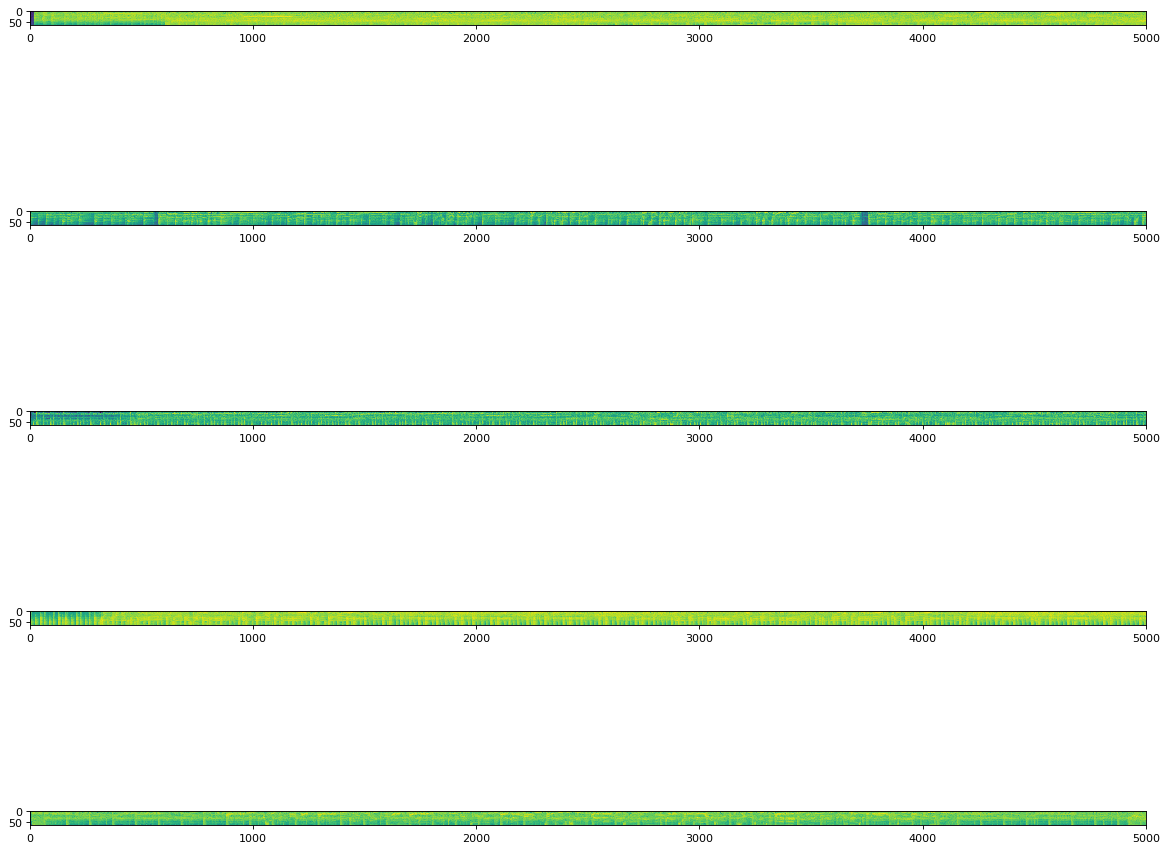

In [52]:
import subprocess

def find_song_file(i):
    song_name = splitext(split(flat_files[i])[1])[0]
    for song_path in wav_files:
        if song_name in song_path:
            return song_path

# for i in [163, 14]:
#     subprocess.run(['cp', find_song_file(i), '/home/sean/Music'])

fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

song_ids = [20, 101, 12, 113, 29]
for i, song_id in enumerate(cluster):
    song_path = find_song_file(song_id)
    
    subprocess.run(['cp', song_path, '/home/sean/Music'])
    
    if i < 5:
        waveform = read_waveform(song_path)
        signals = tf.reshape(waveform, [1, -1])
        stfts = tf.contrib.signal.stft(signals, frame_length=1024, frame_step=512, fft_length=1024)
        magnitude_spectrograms = tf.abs(stfts)
        num_spectrogram_bins = magnitude_spectrograms.shape[-1].value

        sampling_rate, lower_edge_hertz, upper_edge_hertz, num_mel_bins = 44100, 80.0, 8000, 64

        linear_to_mel_weight_matrix = tf.contrib.signal.linear_to_mel_weight_matrix(
            num_mel_bins, 
            num_spectrogram_bins, 
            sampling_rate, 
            lower_edge_hertz, 
            upper_edge_hertz
        )

        mel_spectrograms = tf.tensordot(magnitude_spectrograms, linear_to_mel_weight_matrix, 1)

        log_offset = 1e-6
        log_mel_spectrograms = tf.log(mel_spectrograms + log_offset)

        array = log_mel_spectrograms.numpy()[0][:target_length, :]
        print(array.shape)
        subplt = plt.subplot(len(song_ids), 1, i + 1)
        subplt.imshow(np.swapaxes(array,0,1))

In [61]:
import re

f = open('embedded.csv', 'w')

for i, v in enumerate(embedded):
    print(i)
    song_path = find_song_file(i)
    song_name = splitext(split(song_path)[1])[0]
    print(re.findall('[0-9][0-9][0-9] - (.+) - (.+)', song_name))
    author, title = re.findall('[0-9][0-9][0-9] - (.+) - (.+)', song_name)[0]
    line = "{}, \"{}\", \"{}\", {}, {}\n".format(i, title, author, v[0], v[1])
    f.write(line)
    
f.close()

0
[('Thnk Void', 'Dume')]
1
[('Raina Solway', 'Keep Us Together')]
2
[('The Dig', 'Say Hello To Alison')]
3
[('Okey Dokey', 'Whose Heart')]
4
[('Yo & The South', "When I'm Gone")]
5
[('Inning', 'White Girls, Black Jackets')]
6
[('Pleasure Nature', 'Window Eyes (feat. Pawn)')]
7
[('Brandon Hoogenboom', "You Don't Know Me")]
8
[('Made-Up', "Who's Mess, Who's Tears")]
9
[('mellow fellow', 'yours alone')]
10
[('Secret American', 'WHY BELIEVE')]
11
[('Oro Swimming Hour', 'Zzz')]
12
[('Strüds Munroe', 'Wollow')]
13
[('sailawway', 'Yearning')]
14
[('Orchid Mantis', 'Yellow House')]
15
[('BUHU', 'Yew')]
16
[('Oscar Lang', 'you.')]
17
[('draag', 'Your Better Half Is Dead')]
18
[('ST. MARTiiNS', 'Jazzboy')]
19
[('Bobey', 'Melon Cauliflower')]
20
[('boy scouts', 'Kite')]
21
[('Cousin Kula', 'Jelly Love')]
22
[('Ocean Potion', 'Lights Out')]
23
[('Orange Joe', 'Lady Lovely (Demo)')]
24
[('Provoker', 'Sex With My Ex')]
25
[('Yumi Zouma', 'In Camera')]
26
[('Aaron Taos', 'Loneliness')]
27
[('Barrie'

[('Jack Conman', 'Existential Crisis (Kev La Kat Remix)')]
785
[('Love Lake', 'Doves')]
786
[('Yot Club', 'Faded')]
787
[('nep', "fallin'")]
788
[('Okemo', 'Fake Sunshine')]
789
[('Sports Day', 'Shook')]
790
[('Twist', 'Tides')]
791
[('banzai florist', 'yikes cream')]
792
[('Goth Babe', 'Sunnnn')]
793
[('Spooky Cigarette', 'Slowly')]
794
[('Summer Heart', 'Touch')]
795
[('tough boy', 'sleeves')]
796
[('Varsity', 'The Dogs Only Listen to Him')]
797
[('Foxwarren', 'To Be')]
798
[('JAKOMO', 'Tsjkn')]
799
[('Jesus Noris', 'Slow Caffeine (ft. rin)')]
800
[('Mike Edge', "So You're Young")]
801
[('Selfsteam', 'Sushi')]
802
[('wes park', 'You Make Me Melt')]
803
[('Candy', 'Validation')]
804
[('Kevin Pesto', 'Snow')]
805
[('Two People', 'Phone Call')]
806
[('Unknown Caller', 'See You Again')]
807
[('Free Love (FKA Happy Meals)', 'Playing as Punks')]
808
[('GRMLN', 'Soak')]
809
[('Haulm', 'Settle')]
810
[('Helado Negro', "Please Won't Please")]
811
[('Pearl Sugar', 'Scarlet')]
812
[('TOPAZ', 'T